# Final Project Data Science Beginner - Identifikasi Otomatis Mineral Sederhana
# Rafli Fadhlurrohman (2210511104)

# Import Library

In [1]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# Mounting Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip File

In [3]:
zip_path = "/content/drive/My Drive/Dataset/mineral.zip"
extract_path = "/content/mineral_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Isi folder ekstrak:")
print(os.listdir(extract_path))

Isi folder ekstrak:
['mineral']


# Data Cleaning

In [4]:
path = "/content/mineral_dataset/mineral"
total_rusak = 0

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            img = Image.open(file_path)
            img.verify()
        except (IOError, SyntaxError):
            print(f"File rusak dan dihapus: {file_path}")
            os.remove(file_path)
            total_rusak += 1

print(f"Total gambar rusak yang dihapus: {total_rusak}")

Total gambar rusak yang dihapus: 0


# EDA

In [5]:
train_dir = "/content/mineral_dataset/mineral"
all_class_names = os.listdir(train_dir)

for class_name in all_class_names:
    count = len(os.listdir(os.path.join(train_dir, class_name)))
    print(f"{class_name}: {count} gambar")

quartz: 1185 gambar
pyrite: 1086 gambar
biotite: 1070 gambar
chrysocolla: 540 gambar
bornite: 419 gambar
muscovite: 344 gambar
malachite: 998 gambar


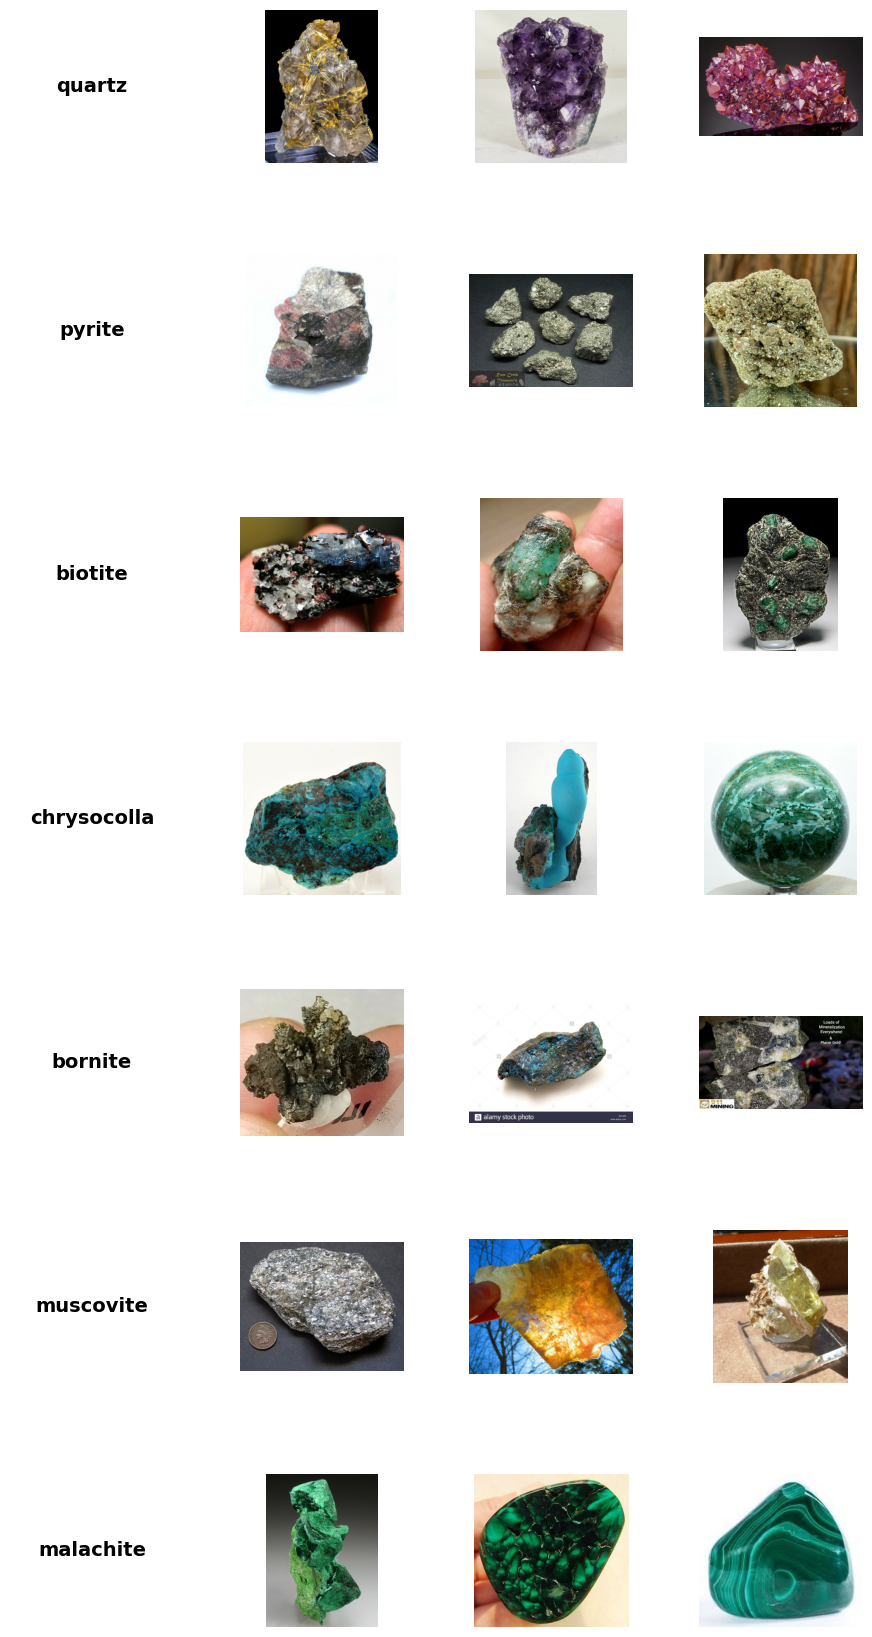

In [6]:
num_classes = 7
num_images_per_class = 3
class_names = os.listdir(train_dir)[:num_classes]

fig, axs = plt.subplots(num_classes, num_images_per_class + 1, figsize=(num_images_per_class * 3 + 2, num_classes * 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)[:num_images_per_class]

    axs[i, 0].text(0.5, 0.5, class_name, fontsize=14, ha='center', va='center', weight='bold')
    axs[i, 0].axis('off')

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        axs[i, j+1].imshow(img)
        axs[i, j+1].axis('off')

plt.show()

<ipython-input-7-c5b36ec62ce0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='Set2')


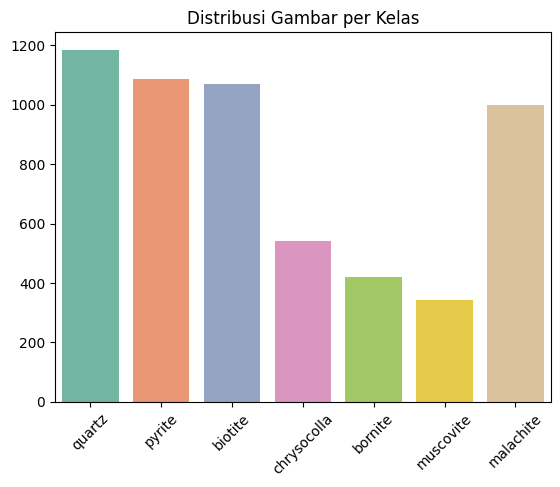

In [7]:
labels = []
counts = []
for class_name in class_names:
    count = len(os.listdir(os.path.join(train_dir, class_name)))
    labels.append(class_name)
    counts.append(count)

sns.barplot(x=labels, y=counts, palette='Set2')
plt.xticks(rotation=45)
plt.title("Distribusi Gambar per Kelas")
plt.show()

# Data Augmentasi

In [8]:
img_height = 150
img_width = 150
batch_size = 32
num_classes = 7

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Membagi Data

In [9]:
train_dir = "/content/mineral_dataset/mineral"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4515 images belonging to 7 classes.
Found 1125 images belonging to 7 classes.


# Membangun Model

In [10]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-10-4ec127aee74e>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Callbacks

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Training Model

In [12]:
initial_epochs = 10
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 105s 655ms/step - accuracy: 0.4023 - loss: 1.7467 - val_accuracy: 0.6116 - val_loss: 1.0267 - learning_rate: 0.0010
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 126s 586ms/step - accuracy: 0.6076 - loss: 1.1028 - val_accuracy: 0.6693 - val_loss: 0.9186 - learning_rate: 0.0010
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 93s 653ms/step - accuracy: 0.6696 - loss: 0.9434 - val_accuracy: 0.6951 - val_loss: 0.8474 - learning_rate: 0.0010
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 92s 652ms/step - accuracy: 0.7076 - loss: 0.8310 - val_accuracy: 0.7049 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 580ms/step - accuracy: 0.7225 - loss: 0.7930 - val_accuracy: 0.7413 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.7463 - loss: 0.7055 - val_accuracy: 0.6862 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0

In [13]:
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 2,191,175 (8.36 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [14]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 10/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 135s 766ms/step - accuracy: 0.6261 - loss: 1.0607 - val_accuracy: 0.7662 - val_loss: 0.8406 - learning_rate: 1.0000e-04
Epoch 11/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 98s 690ms/step - accuracy: 0.7983 - loss: 0.5803 - val_accuracy: 0.7182 - val_loss: 1.1316 - learning_rate: 1.0000e-04
Epoch 12/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 91s 641ms/step - accuracy: 0.8534 - loss: 0.4352 - val_accuracy: 0.7324 - val_loss: 0.9686 - learning_rate: 1.0000e-04
Epoch 13/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 91s 640ms/step - accuracy: 0.8622 - loss: 0.4088 - val_accuracy: 0.7840 - val_loss: 0.7773 - learning_rate: 1.0000e-04
Epoch 14/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.8879 - loss: 0.3322 - val_accuracy: 0.7111 - val_loss: 1.1899 - learning_rate: 1.0000e-04
Epoch 15/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 631ms/step - accuracy: 0.9127 - loss: 0.2724 - val_accuracy: 0.6978 - val_loss: 1.2758 - learning_rate: 1.0000e-04
Epoch 16/40
142/142 ━━━━━━━━━━━━━━━━━━━

# Visualisasi Hasil Training

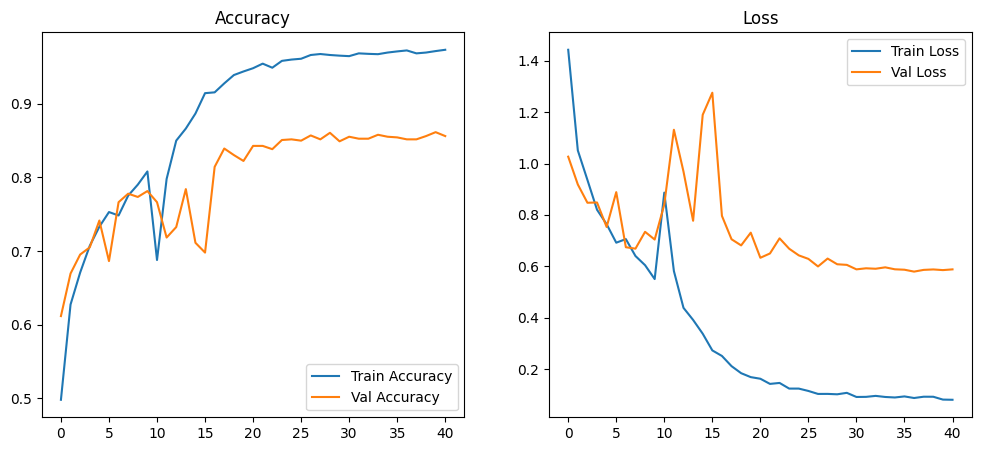

In [15]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

In [16]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.8504 - loss: 0.5289
Validation Accuracy: 0.85


# Evaluasi Model

In [17]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step

Classification Report:
              precision    recall  f1-score   support

     biotite       0.92      0.92      0.92       214
     bornite       0.66      0.86      0.74        83
 chrysocolla       0.69      0.77      0.73       107
   malachite       0.91      0.76      0.83       199
   muscovite       0.64      0.56      0.60        68
      pyrite       0.91      0.91      0.91       217
      quartz       0.92      0.94      0.93       237

    accuracy                           0.85      1125
   macro avg       0.81      0.81      0.81      1125
weighted avg       0.86      0.85      0.85      1125



In [18]:
true_labels = []
predicted_labels = []

class_names = list(train_generator.class_indices.keys())

for images, labels in val_generator:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= val_generator.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

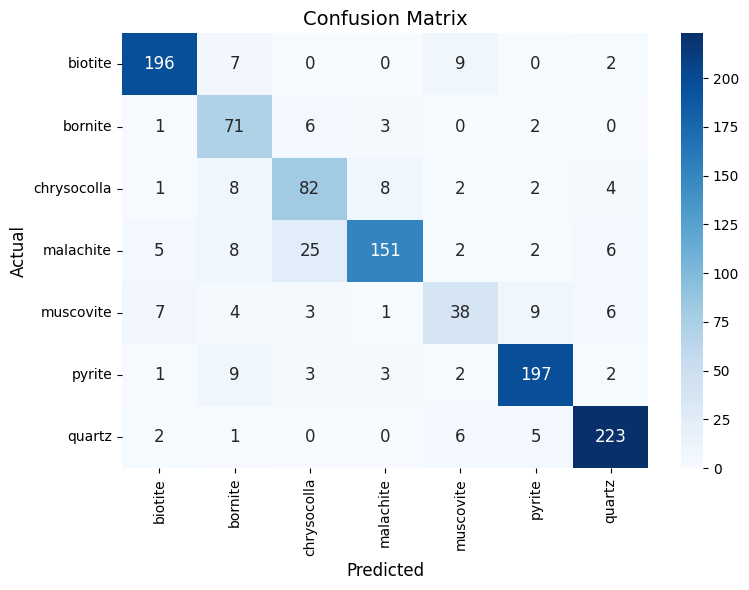

In [19]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# Save Model

In [20]:
model.save("model_mineral.h5")